### Setup

Just run all these cells

In [308]:
import os
import sys
import glob
import numpy as np

import warnings

from astropy.table import Table
from astropy.io import fits

from desitarget.targetmask import mws_mask, bgs_mask, desi_mask, scnd_mask

from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.pyplot as pl
%matplotlib inline

viewer_url_template = "https://www.legacysurvey.org/viewer-desi?ra={ra}&dec={dec}&layer=ls-dr9&zoom=16"
cutout_url_template = "https://www.legacysurvey.org/viewer-desi/cutout.jpg?ra={ra}&dec={dec}&layer=ls-dr9&pixscale=0.13"

In [487]:
def gather_data(night,expid,fiber):
    """
    """
    nightwatch_dir = "/global/cfs/cdirs/desi/spectro/nightwatch/kpno/{night:d}/{expid:08d}".format(night=int(night),
                                                                                                   expid=int(expid))
        
    coordinates_fn = os.path.join(nightwatch_dir,"coordinates-{expid:08d}.fits".format(expid=int(expid)))
    coordinates = Table.read(coordinates_fn)

    fa_fiber = np.asarray(coordinates['FA_FIBER'],dtype=np.int32)
    
    idx = np.flatnonzero(fa_fiber == fiber)
    petal = coordinates['PETAL_LOC'][idx][0]
    ifib  = FIBER - 500*petal

    fa_glob = "/global/cfs/cdirs/desi/spectro/data/{night:d}/{expid:08d}/fiberassign-*.fits.gz".format(night=int(night),
                                                                                                       expid=int(expid))
    fa_files = glob.glob(fa_glob)
    assert(len(fa_files) == 1)
    fa_fn = fa_files[0]

    retdict = dict()
        
    fa = Table.read(fa_fn,'FIBERASSIGN')
    retdict['FA'] = fa
    
    target = fa[fa['FIBER'] == fiber][0]
    retdict['TARGET'] = target
    retdict['RA'] = np.float32(target['TARGET_RA'])
    retdict['DEC'] = np.float32(target['TARGET_DEC'])

    retdict['B'] = dict()
    retdict['R'] = dict()
    retdict['Z'] = dict()

    for _ in 'BRZ':
        fn = os.path.join(nightwatch_dir,"qcframe-{arm}{petal:d}-{expid:08d}.fits".format(
            arm=_.lower(), petal=int(petal), expid=int(expid)))
        retdict[_]['WAVELENGTH'] = fits.getdata(fn,extname="WAVELENGTH")[ifib]
        retdict[_]['FLUX'] = fits.getdata(fn,extname="FLUX")[ifib]
        retdict[_]['IVAR'] = fits.getdata(fn,extname="IVAR")[ifib]
        retdict[_]['MASK'] = fits.getdata(fn,extname="MASK")[ifib]
        
    retdict['viewer_url'] = viewer_url_template.format(ra = retdict['RA'], dec = retdict['DEC'])
    retdict['cutout_url'] = cutout_url_template.format(ra = retdict['RA'], dec = retdict['DEC'])
    
    return retdict

In [557]:
def summary(d):
    """
    """
    t = d['TARGET']
    fa = d['FA']
    
    g = 22.5 - np.log10(t['FLUX_G'])
    r = 22.5 - np.log10(t['FLUX_R'])
    z = 22.5 - np.log10(t['FLUX_Z'])
    
    print(d['viewer_url'])
    print()
    print('TARGETID: {}'.format(t['TARGETID']))
    print(d['RA'],d['DEC'])
    print('Gaia G mag:',t['GAIA_PHOT_G_MEAN_MAG'])
    print('g,r,z, g-r: {:4.2f},  {:4.2f},  {:4.2f}, {:4.2f}'.format(g,r,z, g-r))
    print()
    if t['DESI_TARGET'] > 0:
        desi_names = desi_mask.names(t['DESI_TARGET'])
        print('DESI:', desi_names)
    if t['MWS_TARGET'] > 0:
        mws_names = mws_mask.names(t['MWS_TARGET'])
        print('MWS: ', mws_names)
    if t['BGS_TARGET'] > 0:
        bgs_names = bgs_mask.names(t['BGS_TARGET'])
        print('BGS :', bgs_names)
    if t['SCND_TARGET'] > 0:
        scnd_names = scnd_mask.names(t['SCND_TARGET'])
        print('SNCD:', scnd_names)          
    print()
    display(t)
    print()

    display(Image(url=d['cutout_url']))
    
    med_flux = np.median(np.concatenate([d['B']['FLUX'],d['R']['FLUX'],d['Z']['FLUX']]))
    mad = np.median(np.concatenate([np.abs(d['B']['FLUX']-med_flux),
                                    np.abs(d['R']['FLUX']-med_flux),
                                    np.abs(d['Z']['FLUX']-med_flux)]))
    
    NSAMPLE = 10
        
    pl.figure(figsize=(15,4))
    pl.plot(d['B']['WAVELENGTH'][::NSAMPLE],d['B']['FLUX'][::NSAMPLE],c='b',lw=0.5)
    pl.plot(d['R']['WAVELENGTH'][::NSAMPLE],d['R']['FLUX'][::NSAMPLE],c='r',lw=0.5)
    pl.plot(d['Z']['WAVELENGTH'][::NSAMPLE],d['Z']['FLUX'][::NSAMPLE],c='g',lw=0.5)
    pl.grid()
    pl.axhline(med_flux,c='k',ls='--',zorder=-10)

    NSAMPLE = 1
    
    pl.figure(figsize=(15,2))
    pl.plot(d['B']['WAVELENGTH'][::NSAMPLE],d['B']['FLUX'][::NSAMPLE],c='b',lw=0.5)
    pl.ylim(med_flux-3*mad,med_flux+3*mad)   
    pl.grid()

    pl.figure(figsize=(15,2))
    pl.plot(d['R']['WAVELENGTH'][::NSAMPLE],d['R']['FLUX'][::NSAMPLE],c='r',lw=0.5)
    pl.ylim(med_flux-3*mad,med_flux+3*mad)   
    pl.grid()
           
    pl.figure(figsize=(15,2))
    pl.plot(d['Z']['WAVELENGTH'][::NSAMPLE],d['Z']['FLUX'][::NSAMPLE],c='g',lw=0.5)
    pl.ylim(med_flux-3*mad,med_flux+3*mad)   
    pl.grid()
    
    g_all = 22.5 - np.log10(fa['FLUX_G'])
    r_all = 22.5 - np.log10(fa['FLUX_R'])
    z_all = 22.5 - np.log10(fa['FLUX_Z'])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.figure(figsize=(6,6))
        pl.hexbin(g_all-r_all,r_all-z_all,bins='log',gridsize=100)
        pl.scatter(g-r,r-z,s=20,c='r')
        pl.xlabel('g-r')
        pl.ylabel('r-z')
        pl.grid()

### Working

Only need to set the night once...

In [558]:
NIGHT = 20210604

Change these and re-run as needed

https://www.legacysurvey.org/viewer-desi?ra=202.43551635742188&dec=8.467533111572266&layer=ls-dr9&zoom=16

TARGETID: 39627992871211974
202.43552 8.467533
Gaia G mag: 16.238947
g,r,z, g-r: 20.15,  19.96,  19.89, 0.19

DESI: ['MWS_ANY']
MWS:  ['MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_SOUTH']



TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64
39627992871211974,3,295,3295,1780,0,202.43552058699717,8.467532638904395,-2.0372045,-9.478801,2015.5,5400.0,2305843009213693952,1,TGT,330.7281,25.14884,1500,0.6308789230214448,516,9010,379993,5062,PSF,225.97728,347.87982,403.34134,62.4368,31.095913,32.62783,0,3719834036484265216,G2,16.238947,16.590963,15.7177105,0.5360385,2023p085,0.024845038,115.10446,61.074398,1.686395,0.5627738,175.02818,269.44644,312.40356,175.02818,269.44644,312.40356,0.0,0.0,0.0,0.0,S,1500,2,2305843009213693952,0,1280,0,202.43552058699717,8.467532638904395


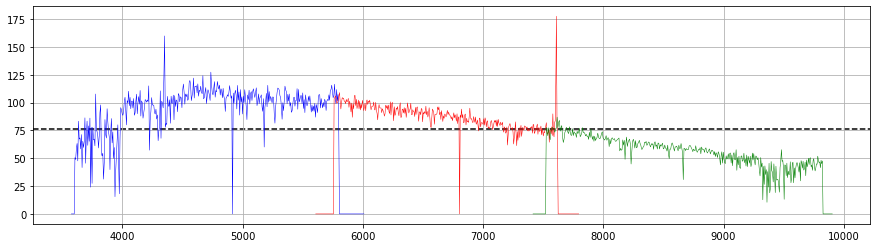

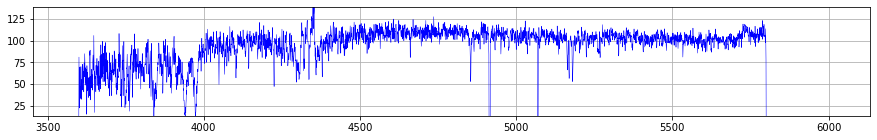

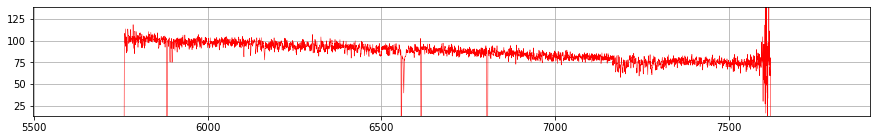

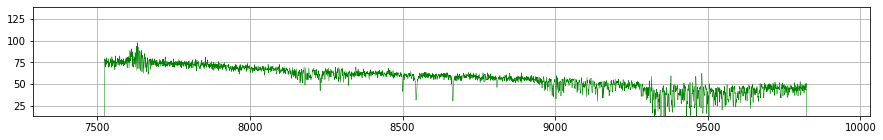

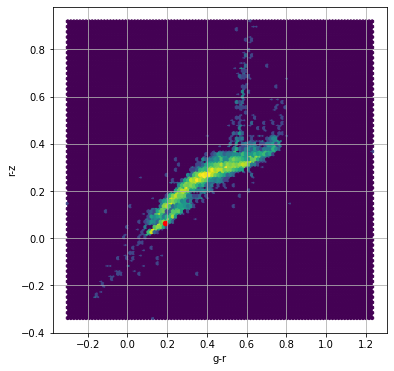

In [559]:
EXPID = 91169
FIBER = 1780
summary(gather_data(NIGHT,EXPID,FIBER))